# 인공지능문제해결 중간고사

## House Prices - Advanced Regression Techniques

### 주택 데이터를 활용하여 주택 가격을 예측하는 회귀 모델 개발

### 평가 지표: RMSE (Root Mean Squared Error)

### 제출 방법: 본 ipynb 파일을 LMS에 첨부로 제출

### 1. 초기 설정 및 데이터 로드

#### 1.1 기본 라이브러리 설치 및 로드 (필요시 추가 가능)

In [65]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm bayesian-optimization

In [66]:
# 데이터 처리 및 분석
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 및 평가
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

# 회귀 모델
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# 베이지안 최적화 라이브러리
from bayes_opt import BayesianOptimization

In [67]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("--- RMSE 평가 함수 정의 완료 ---")

--- RMSE 평가 함수 정의 완료 ---


#### 1.2 데이터 로드 및 결합

In [68]:
# ----------------------------------------------------------------------
# 1.2.1 데이터 로드
# ----------------------------------------------------------------------
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# ----------------------------------------------------------------------
# 1.2.2 분석을 위한 핵심 변수 목록 선정
# ----------------------------------------------------------------------
selected_columns = [
    'Id', 'SalePrice', # 데이터 ID와 타깃값
    
    # 핵심 예측 변수 (수치형)
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 
    '2ndFlrSF', 'LowQualFinSF', 'TotRmsAbvGrd', 'Fireplaces', 
    'GarageArea', 'PoolArea', 'MiscVal', 'MSSubClass', 
    
    # 시간 관련 피처 (피처 엔지니어링 유도)
    'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold', 
    
    # 차고, 지하실, 마당 관련 (결측값/인코딩)
    'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 
    'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
    'BsmtFinType1', 'PoolQC',
    
    # 품질/상태 등급 (순서형/명목형)
    'OverallCond', 'ExterQual', 'ExterCond', 'KitchenQual', 
    'HeatingQC', 'Heating', 'CentralAir', 'PavedDrive',
    
    # 위치/유형/조건 (명목형/이진형)
    'MSZoning', 'Neighborhood', 'BldgType', 'SaleCondition',
]

train_df = train_df[selected_columns]
test_selected_columns = [col for col in selected_columns if col != 'SalePrice']
test_df = test_df[test_selected_columns]

# ----------------------------------------------------------------------
# 1.2.3 모든 변수명 한글화 적용
# ----------------------------------------------------------------------
rename_map = {
    # 데이터 ID 및 타깃값
    'Id': '거래_ID',
    'SalePrice': '판매_가격', 
    # 핵심 예측 변수
    'OverallQual': '전반적_자재_품질', 'GrLivArea': '지상층_주거_면적', 
    'TotalBsmtSF': '지하실_총_면적', '1stFlrSF': '1층_면적', 
    '2ndFlrSF': '2층_면적', 'LowQualFinSF': '저품질_마감_면적', 
    'TotRmsAbvGrd': '지상층_총_방수', 'Fireplaces': '벽난로_수', 
    'GarageArea': '차고_면적', 'PoolArea': '풀장_면적', 
    'MiscVal': '기타_가치', 'MSSubClass': '주택_유형', 
    # 시간 관련
    'YearBuilt': '건축_연도', 'YearRemodAdd': '리모델링_연도', 
    'YrSold': '판매_연도', 'MoSold': '판매_월', 
    # 차고/지하실/풀
    'GarageType': '차고_위치', 'GarageFinish': '차고_마감', 
    'GarageCars': '차량_수용_대수', 'GarageQual': '차고_품질', 
    'GarageCond': '차고_상태', 'BsmtQual': '지하실_높이_품질', 
    'BsmtCond': '지하실_상태', 'BsmtExposure': '지하실_노출', 
    'BsmtFinType1': '지하실_마감_1', 'PoolQC': '풀장_품질',
    # 품질/상태 등급
    'OverallCond': '전반적_상태_등급', 'ExterQual': '외장_재료_품질', 
    'ExterCond': '외장_재료_상태', 'KitchenQual': '주방_품질', 
    'HeatingQC': '난방_품질', 'Heating': '난방_유형', 
    'CentralAir': '중앙_냉방_여부', 'PavedDrive': '포장_도로_여부',
    # 위치/유형/조건
    'MSZoning': '일반_구역_분류', 'Neighborhood': '지역_명', 
    'BldgType': '주거_유형', 'SaleCondition': '판매_조건',
}

# 변수명 일괄 변경
train_df.rename(columns=rename_map, inplace=True)
test_df.rename(columns=rename_map, inplace=True)

# ----------------------------------------------------------------------
# 1.4. 데이터 분리 및 통합
# ----------------------------------------------------------------------
train_ids = train_df['거래_ID']
test_ids = test_df['거래_ID']

# 원본 데이터 백업
original_train_df = train_df.copy()

X_train = train_df.drop(['거래_ID', '판매_가격'], axis=1)
X_test = test_df.drop('거래_ID', axis=1)
y_train = train_df['판매_가격']

# 전처리를 위해 학습 및 테스트 데이터를 통합 (Id와 Target 제외)
all_df = pd.concat([X_train, X_test], ignore_index=True)

print(f"--- 최종 분석 데이터 (all_df) shape: {all_df.shape} ({all_df.shape[1]}개 변수) ---")
all_df.head()

--- 최종 분석 데이터 (all_df) shape: (2919, 38) (38개 변수) ---


,전반적_자재_품질,지상층_주거_면적,지하실_총_면적,1층_면적,2층_면적,저품질_마감_면적,지상층_총_방수,벽난로_수,차고_면적,풀장_면적,...,외장_재료_상태,주방_품질,난방_품질,난방_유형,중앙_냉방_여부,포장_도로_여부,일반_구역_분류,지역_명,주거_유형,판매_조건
0,7,1710,856.0,856,854,0,8,0,548.0,0,...,TA,Gd,Ex,GasA,Y,Y,RL,CollgCr,1Fam,Normal
1,6,1262,1262.0,1262,0,0,6,1,460.0,0,...,TA,TA,Ex,GasA,Y,Y,RL,Veenker,1Fam,Normal
2,7,1786,920.0,920,866,0,6,1,608.0,0,...,TA,Gd,Ex,GasA,Y,Y,RL,CollgCr,1Fam,Normal
3,7,1717,756.0,961,756,0,7,1,642.0,0,...,TA,Gd,Gd,GasA,Y,Y,RL,Crawfor,1Fam,Abnorml
4,8,2198,1145.0,1145,1053,0,9,1,836.0,0,...,TA,Gd,Ex,GasA,Y,Y,RL,NoRidge,1Fam,Normal


### 2. 탐색적 데이터 분석

| 한글 변수명 | 기존 변수명 | 변수 유형 | 상세 설명 |
| :--- | :--- | :--- | :--- |
| **판매_가격** | `SalePrice` | 수치형 (타깃) | 주택의 최종 판매 가격 (USD) |
| **거래_ID** | `Id` | 식별자 | 거래 고유 ID (분석에서 제외) |
| **전반적_자재_품질** | `OverallQual` | 순서형 | 주택 자재 및 마감의 전반적인 품질 (1:Very Poor ~ 10:Very Excellent) |
| **전반적_상태_등급** | `OverallCond` | 순서형 | 주택의 전반적인 상태 등급 (1:Very Poor ~ 9:Very Excellent) |
| **지상층_주거_면적** | `GrLivArea` | 수치형 | 지상 1층 및 2층의 총 주거 면적 (제곱피트) |
| **지하실_총_면적** | `TotalBsmtSF` | 수치형 | 지하실 총 면적 (제곱피트) |
| **1층_면적** | `1stFlrSF` | 수치형 | 지상 1층 면적 (제곱피트) |
| **2층_면적** | `2ndFlrSF` | 수치형 | 지상 2층 면적 (제곱피트) |
| **저품질_마감_면적** | `LowQualFinSF` | 수치형 | 저품질로 마감된 전체 면적 (제곱피트) |
| **지상층_총_방수** | `TotRmsAbvGrd` | 수치형 | 지상층의 총 방 개수 (욕실 제외) |
| **벽난로_수** | `Fireplaces` | 수치형 | 벽난로 개수 |
| **차고_면적** | `GarageArea` | 수치형 | 차고 면적 (제곱피트) |
| **풀장_면적** | `PoolArea` | 수치형 | 풀장 면적 (제곱피트) |
| **기타_가치** | `MiscVal` | 수치형 | $500 이상 기타 특징의 가치 |
| **주택_유형** | `MSSubClass` | 명목형 | 주거 유형 식별 코드 (예: 20=1층 신축 주택) |
| **건축_연도** | `YearBuilt` | 수치형 (시간) | 주택 건축 연도 |
| **리모델링_연도** | `YearRemodAdd` | 수치형 (시간) | 리모델링 연도 (개조되지 않은 경우 건축 연도와 동일) |
| **판매_연도** | `YrSold` | 수치형 (시간) | 판매가 이루어진 연도 |
| **판매_월** | `MoSold` | 수치형 (시간) | 판매가 이루어진 월 |
| **차고_위치** | `GarageType` | 명목형 | 차고 위치 (예: Attached, Detached 등) |
| **차고_마감** | `GarageFinish` | 순서형 | 차고 내부 마감 (Fin, RFn, Unf) |
| **차량_수용_대수** | `GarageCars` | 수치형 | 차고에 수용 가능한 자동차 수 |
| **차고_품질** | `GarageQual` | 순서형 | 차고 품질 (Ex, Gd, TA, Fa, Po, NA) |
| **차고_상태** | `GarageCond` | 순서형 | 차고 상태 (Ex, Gd, TA, Fa, Po, NA) |
| **지하실_높이_품질** | `BsmtQual` | 순서형 | 지하실 높이/품질 (Ex, Gd, TA, Fa, Po, NA) |
| **지하실_상태** | `BsmtCond` | 순서형 | 지하실 일반 상태 (Ex, Gd, TA, Fa, Po, NA) |
| **지하실_노출** | `BsmtExposure` | 순서형 | 지하실 벽의 노출 여부 (Gd, Av, Mn, No, NA) |
| **지하실_마감_1** | `BsmtFinType1` | 순서형 | 지하실 마감 면적 유형 1 (GLQ, ALQ 등) |
| **풀장_품질** | `PoolQC` | 순서형 | 풀장 품질 (Ex, Gd, TA, Fa, NA) |
| **외장_재료_품질** | `ExterQual` | 순서형 | 외장재 품질 (Ex, Gd, TA, Fa, Po) |
| **외장_재료_상태** | `ExterCond` | 순서형 | 외장재 상태 (Ex, Gd, TA, Fa, Po) |
| **주방_품질** | `KitchenQual` | 순서형 | 주방 품질 (Ex, Gd, TA, Fa, Po) |
| **난방_품질** | `HeatingQC` | 순서형 | 난방 품질 및 상태 (Ex, Gd, TA, Fa, Po) |
| **난방_유형** | `Heating` | 명목형 | 난방 유형 (GasA, GasW 등) |
| **중앙_냉방_여부** | `CentralAir` | 이진형 (명목) | 중앙 냉방 여부 (Y: Yes, N: No) |
| **포장_도로_여부** | `PavedDrive` | 순서형 | 차고/주차 공간 포장 도로 여부 (Y, P, N) |
| **일반_구역_분류** | `MSZoning` | 명목형 | 일반 구역 분류 (예: 주거, 상업 등) |
| **지역_명** | `Neighborhood` | 명목형 | 물리적인 위치 (Ames 시의 경계 내) |
| **주거_유형** | `BldgType` | 명목형 | 주거 유형 (예: 단독 주택, 타운하우스 등) |
| **판매_조건** | `SaleCondition` | 명목형 | 판매 조건 (예: Normal, Abnorml 등) |

#### 2.1 타깃값(판매_가격) 분포 분석 및 전처리
- [필수] 타깃값의 분포를 시각화하고, 왜 log 변환이 필요한지 설명하시오.

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

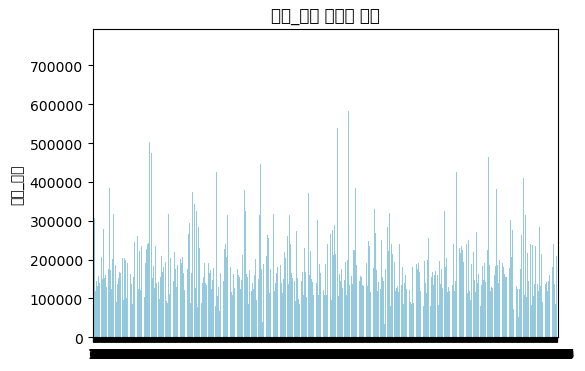

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

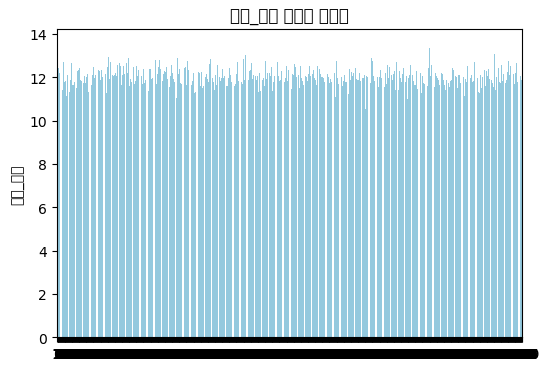

In [70]:
# [코드] 판매_가격 분포도 확인
plt.figure(figsize=(6,4))
sns.barplot(y_train, color='skyblue')
plt.title("판매_가격 분포도 확인")
plt.show()

# [코드] 판매_가격 로그 변환 (로그 변환을 적용하세요)
y_train_log = np.log1p(y_train)

# [코드] 로그 변환된 판매_가격 분포도 재확인 
plt.figure(figsize=(6,4))
sns.barplot(y_train_log, color='skyblue')
plt.title("판매_가격 분포도 재확인")
plt.show()

# [설명] 로그 변환이 필요한 이유에 대한 설명
# 판매_가격의 분포가 값의 차이가 크기 때문에 로그변환이 필요하다

#### 2.2 결측값 분석 및 처리
- [필수] 결측값 현황을 파악하고, 적절한 처리를 수행하시오. 어떤 처리 전략을 선택했는지, 그리고 그 이유는 무엇인지 설명하시오.

In [71]:
# [코드] 결측값 현황 파악
print(all_df.isnull().sum().sort_values(ascending=False).head(10))

# [코드] 결측값 처리 코드
num_cols = all_df.select_dtypes(include=[np.number]).columns
cat_cols = all_df.select_dtypes(exclude=[np.number]).columns
for col in num_cols:
    all_df[col].fillna(all_df[col].median(), inplace=True)
for col in cat_cols:
    all_df[col].fillna(all_df[col].mode()[0], inplace=True)

# [설명] 결측값 처리 전략 및 이유 설명
# 숫자형인 num_cols는 중앙값으로 결측치를 대체하고, 범주형인 cat_cols는 최빈값으로 결측치를 대체하여 값들이 이상치로 튀지 않도록 했다.

풀장_품질        2909
차고_품질         159
차고_상태         159
차고_마감         159
차고_위치         157
지하실_노출         82
지하실_상태         82
지하실_높이_품질      81
지하실_마감_1       79
일반_구역_분류        4
dtype: int64


#### 2.3 이상치 분석 및 처리
- [필수] 주요 피처(예: 지상층_주거_면적, 지하실_총_면적)와 타깃값(판매_가격) 간의 산점도를 그려 이상치 현황을 파악하고, 적절한 처리를 수행하시오. 어떤 처리 전략을 선택했는지, 그리고 그 이유는 무엇인지 설명하시오.

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

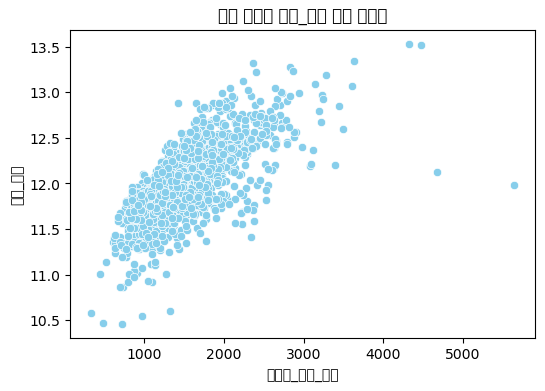

In [72]:
# [코드] 주요 피처와 판매_가격 간의 산점도 시각화
plt.figure(figsize=(6,4))
sns.scatterplot(x=all_df['지상층_주거_면적'], y=y_train_log ,color='skyblue')
plt.title("주요 피처와 판매_가격 간의 산점도")
plt.show()

# [코드] 이상치 처리 코드
all_df['지상층_주거_면적'] = (all_df['지상층_주거_면적'] < 4000).astype(int)

# [설명] 이상치 처리 전략 및 이유 설명
# 4000이하로 값들이 몰려있고 그 이상으로 넘어가는 이상치가 있으므로, 4000이하의 값들만 선택하여 과적합을 방지한다.

### 3. 피처 엔지니어링 및 인코딩

In [73]:
# 자유 분석 공간: 이 셀을 이용해 자유롭게 분석을 진행하시오.

In [74]:
# 자유 분석 공간: 특정 피처를 제거하거나, 값을 가공하거나, 파생 피처에 대한 아이디어를 얻는 데 활용하시오.

In [75]:
# 자유 분석 공간: 필요하면 이렇게 여러 셀을 추가해서 사용하시오.

#### 3.1 파생 피처 생성
- [필수] 최소 2개 이상의 창의적인 파생 피처를 생성하시오. 어떤 피처를 조합했고, 왜 이 피처가 예측에 도움이 될 것이라고 판단했는지 설명하시요.

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

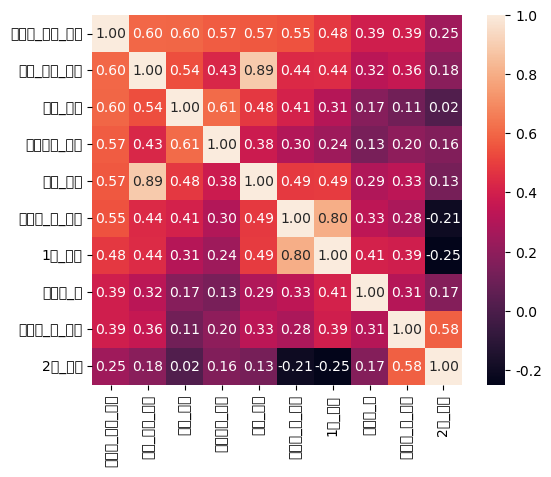

In [76]:
# [코드] 파생 피처 생성
# 1. 전체 면적 합산하기
all_df['TotalSF'] = all_df['지하실_총_면적'] + all_df['1층_면적'] + all_df['2층_면적']
# 2. 품질x면적 상호작용
all_df['QualArea'] = all_df['전반적_자재_품질'] + all_df['지상층_주거_면적']

# [설명] 파생 피처 생성 이유 설명
# 1. 전체 면적 합산 : 세 변수를 합치면 "전체 거주 가능 면적"이라는 단일 지표로 단순화할 수 있음
# 2. 전반적_자재_품질 x 지상층_주거_면적 상호작용 : 같은 면적이라도 품질이 높으면 가격이 급등하므로 강한 양의 상관관계를 지님
corr = all_df[num_cols].corr()
top_corr = corr['전반적_자재_품질'].sort_values(ascending=False).head(10)
cols = top_corr.index
corr_top = all_df[cols].corr()
sns.heatmap(corr_top, annot=True, fmt=".2f", square=True)
plt.show()
# sns.pairplot(all_df[['전반적_자재_품질', '지상층_주거_면적']], diag_kind='kde')

#### 3.2 피처 인코딩 및 스케일링
- [필수] 각 피처에 적절한 인코딩을 적용하시오.
- [선택] 필요하다고 판단되는 수치형 피처에 스케일링을 적용하고 이유를 설명하시오.

In [77]:
# [코드] 인코딩 적용
# import LabelEncoder
# for col in cat_cols:
#     le = LabelEncoder()

# [코드] 스케일링 적용 (선택적)

# [설명] 스케일링 적용 이유 설명 (선택적)

### 4. 모델링 및 하이퍼파라미터 최적화

#### 4.1 데이터 분리

In [83]:
# 전처리된 데이터를 다시 학습/테스트 셋으로 분리
X_train = all_df.iloc[:len(y_train), :]
X_test = all_df.iloc[len(y_train):, :]
y_train = y_train_log.iloc[:len(y_train), :]
y_test = y_train_log.iloc[len(y_train):, :]

# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(all_df, y_train, test_size=0.2, random_state=42)

IndexingError: Too many indexers

#### 4.2 모델 학습 및 최적화 수행
- [필수] 다양한 모델을 훈련시켜보고 성능(RMSE)을 기록하시오.
- [선택] 필요한 경우 그리드 서치 또는 베이지안 최적화 중 하나를 선택하여 수행하고 그 결과를 설명하시오.

In [ ]:
# [코드] 모델 설계 및 학습
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
params = {'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.05,
          'num_leaves': 3,
          'feature_fraction': 0.8,
          'bagging_fraction': 0.8,
          'seed': 42}
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_test, y_test)
model = lgb_train(params, lgb_train, valid_sets=[lgb_train, lgb_val], num_boost_round=10000)

# [코드] 모델 평가 (RMSE 계산)

# [설명] 모델 성능 및 평가 결과 설명
# kaggle에서 가장 많이 쓰이는 모델인 lightgbm을 사용했다. 그 이유는 다른 모델들에 비해 가볍고 가장 효과적으로 성능이 높기 때문이다.

# [코드] 하이퍼파라미터 최적화 (선택적)

# [설명] 최적화 방법 및 결과 설명 (선택적)

TypeError: 'Dataset' object is not callable

### 5. 최종 제출

#### 5.1 최종 예측 및 파일 생성
- [필수] 최종 예측 결과를 확보(앙상블, OOF 등 다양한 기법 적용 가능)하고, 제출 파일 submission.csv 를 생성하시오.

In [ ]:
# [코드] 최종 예측을 위한 코드
final_pred = model.predict(X_test)

# [코드] 로그 역변환 및 제출 파일 생성
final_predictions = np.expm1(final_pred)
submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': final_predictions})
submission_df.to_csv('submission.csv', index=False)

#### 5.2 결론 및 고찰
- [필수] 가장 성능 향상에 기여했다고 생각하는 분석 단계에 대하여 그 이유를 간결하게 설명하시오.
- [필수] 시간 제약으로 시도하지 못했지만 시도해보고 싶은 추가적인 분석에 대해 간략히 서술하시오.

In [ ]:
# [설명] 가장 성능 향상에 기여한 분석 단계 및 이유 설명
# 피처 엔지니어링 부분 중에 파생피처를 만드는 게 가장 기여했다고 생각하고, 그 이유는 상식적으로 타깃 예측과 밀접한 관련이 있어 예측에 도움되는 피처를 생성함으로써 성능이 효육적으로 올라가기 때문이다.
# [설명] 추가적으로 시도해보고 싶은 분석 방법 및 이유 설명
# 앙상블과 같은 다양한 기법을 적용해보고 싶다. 미미하지만 성능 향상에 도움이 될 것이기 때문이다. 